In [1]:
# LangGraph 및 관련 라이브러리 설치
!pip install langgraph langchain langchain-openai langchain-community

  Obtaining dependency information for langgraph from https://files.pythonhosted.org/packages/bb/93/7836486f6c18b0b11e6bde5bc0f318947e610637aa5231081bd4adf79eb9/langgraph-0.6.3-py3-none-any.whl.metadata
  Obtaining dependency information for langchain from https://files.pythonhosted.org/packages/f6/d5/4861816a95b2f6993f1360cfb605aacb015506ee2090433a71de9cca8477/langchain-0.3.27-py3-none-any.whl.metadata
  Using cached langchain-0.3.27-py3-none-any.whl.metadata (7.8 kB)
  Obtaining dependency information for langchain from https://files.pythonhosted.org/packages/f6/d5/4861816a95b2f6993f1360cfb605aacb015506ee2090433a71de9cca8477/langchain-0.3.27-py3-none-any.whl.metadata
  Using cached langchain-0.3.27-py3-none-any.whl.metadata (7.8 kB)
  Obtaining dependency information for langchain-openai from https://files.pythonhosted.org/packages/91/56/75f3d84b69b8bdae521a537697375e1241377627c32b78edcae337093502/langchain_openai-0.3.28-py3-none-any.whl.metadata
  Using cached langchain_openai-0.3.2

In [2]:
# 필수 라이브러리 import
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from typing import TypedDict, Sequence
import os

In [3]:
# OpenAI API 키 설정 (필요한 경우)
# os.environ["OPENAI_API_KEY"] = "your-api-key-here"

# 기본 설정 확인
print("LangGraph 라이브러리가 성공적으로 설치되었습니다!")
print("사용 가능한 주요 모듈:")
print("- StateGraph: 상태 기반 그래프 생성")
print("- ToolNode: 도구 노드 생성") 
print("- ChatOpenAI: OpenAI 채팅 모델")
print("- BaseMessage, HumanMessage, AIMessage: 메시지 타입들")

LangGraph 라이브러리가 성공적으로 설치되었습니다!
사용 가능한 주요 모듈:
- StateGraph: 상태 기반 그래프 생성
- ToolNode: 도구 노드 생성
- ChatOpenAI: OpenAI 채팅 모델
- BaseMessage, HumanMessage, AIMessage: 메시지 타입들


In [4]:
# LangGraph 기본 사용 예제

# 상태 정의
class GraphState(TypedDict):
    messages: Sequence[BaseMessage]

# 간단한 노드 함수 정의
def chatbot_node(state: GraphState):
    """간단한 챗봇 노드"""
    # 마지막 메시지 가져오기
    last_message = state["messages"][-1]
    
    # 간단한 응답 생성 (실제로는 LLM을 사용)
    response = f"안녕하세요! 입력하신 메시지는: '{last_message.content}' 입니다."
    
    return {"messages": [AIMessage(content=response)]}

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("chatbot", chatbot_node)

# 시작점 설정
workflow.set_entry_point("chatbot")

# 종료점 설정
workflow.add_edge("chatbot", END)

# 그래프 컴파일
app = workflow.compile()

print("LangGraph 워크플로우가 성공적으로 생성되었습니다!")

LangGraph 워크플로우가 성공적으로 생성되었습니다!


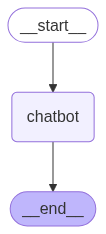

In [6]:
from IPython.display import display, Image
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("이미지를 불러오는 데 실패했습니다:", e)

In [5]:
# 그래프 테스트 실행
initial_state = {
    "messages": [HumanMessage(content="안녕하세요! LangGraph 테스트입니다.")]
}

# 타입을 명확히 지정하여 오류 방지
initial_state["messages"] = list(initial_state["messages"])  # Sequence[BaseMessage]로 명확히

# 그래프 실행
result = app.invoke(initial_state)

print("입력 메시지:", initial_state["messages"][0].content)
print("응답 메시지:", result["messages"][-1].content)

입력 메시지: 안녕하세요! LangGraph 테스트입니다.
응답 메시지: 안녕하세요! 입력하신 메시지는: '안녕하세요! LangGraph 테스트입니다.' 입니다.


In [ ]:
# 분기점이 있는 LangGraph 워크플로우 예제

from typing import Literal

# 확장된 상태 정의
class BranchGraphState(TypedDict):
    messages: Sequence[BaseMessage]
    user_intent: str
    current_step: str

# 의도 분석 노드 (분기점 결정)
def analyze_intent_node(state: BranchGraphState):
    """
    사용자 의도를 분석하는 노드 (Pseudo code)
    """
    last_message = state["messages"][-1].content.lower()
    
    # Pseudo code: 의도 분석 로직
    if "날씨" in last_message or "weather" in last_message:
        intent = "weather"
    elif "음식" in last_message or "맛집" in last_message or "food" in last_message:
        intent = "food"
    elif "안녕" in last_message or "hello" in last_message:
        intent = "greeting"
    else:
        intent = "general"
    
    return {
        "user_intent": intent,
        "current_step": "intent_analyzed"
    }

# 분기 조건 함수 (라우터)
def route_based_on_intent(state: BranchGraphState) -> Literal["weather_node", "food_node", "greeting_node", "general_node"]:
    """
    의도에 따라 다음 노드를 결정하는 라우터
    """
    intent = state.get("user_intent", "general")
    
    if intent == "weather":
        return "weather_node"
    elif intent == "food":
        return "food_node"
    elif intent == "greeting":
        return "greeting_node"
    else:
        return "general_node"

# 각 분기별 처리 노드들
def weather_node(state: BranchGraphState):
    """날씨 관련 응답 노드 (Pseudo code)"""
    # Pseudo code: 날씨 API 호출
    # weather_data = call_weather_api(location)
    # response = generate_weather_response(weather_data)
    
    response = "오늘 날씨는 맑고 기온은 25도입니다. (Pseudo: 실제로는 날씨 API를 호출하여 정보를 가져옵니다)"
    
    return {
        "messages": [AIMessage(content=response)],
        "current_step": "weather_completed"
    }

def food_node(state: BranchGraphState):
    """음식 관련 응답 노드 (Pseudo code)"""
    # Pseudo code: 맛집 데이터베이스 검색
    # restaurants = search_restaurants(location, cuisine_type)
    # response = recommend_restaurants(restaurants)
    
    response = "근처 맛집을 추천드립니다: 김밥천국, 맘스터치 등이 있습니다. (Pseudo: 실제로는 위치 기반 맛집 DB를 검색합니다)"
    
    return {
        "messages": [AIMessage(content=response)],
        "current_step": "food_completed"
    }

def greeting_node(state: BranchGraphState):
    """인사 응답 노드 (Pseudo code)"""
    # Pseudo code: 개인화된 인사말 생성
    # user_profile = get_user_profile(user_id)
    # response = generate_personalized_greeting(user_profile)
    
    response = "안녕하세요! 무엇을 도와드릴까요? (Pseudo: 실제로는 사용자 프로필을 기반으로 개인화된 인사를 생성합니다)"
    
    return {
        "messages": [AIMessage(content=response)],
        "current_step": "greeting_completed"
    }

def general_node(state: BranchGraphState):
    """일반 응답 노드 (Pseudo code)"""
    # Pseudo code: 일반적인 대화 처리
    # context = analyze_conversation_context(state["messages"])
    # response = generate_general_response(context)
    
    response = "죄송합니다. 구체적으로 어떤 도움이 필요하신지 말씀해 주세요. (Pseudo: 실제로는 대화 맥락을 분석하여 적절한 응답을 생성합니다)"
    
    return {
        "messages": [AIMessage(content=response)],
        "current_step": "general_completed"
    }

print("분기점이 있는 노드들이 정의되었습니다!")

In [ ]:
# 분기점 워크플로우 그래프 생성 및 엣지 연결

# 새로운 워크플로우 생성
branch_workflow = StateGraph(BranchGraphState)

# 노드들 추가
branch_workflow.add_node("analyze_intent", analyze_intent_node)
branch_workflow.add_node("weather_node", weather_node)
branch_workflow.add_node("food_node", food_node)
branch_workflow.add_node("greeting_node", greeting_node)
branch_workflow.add_node("general_node", general_node)

# 시작점 설정
branch_workflow.set_entry_point("analyze_intent")

# 조건부 엣지 추가 (분기점)
branch_workflow.add_conditional_edges(
    "analyze_intent",  # 분기 시작 노드
    route_based_on_intent,  # 라우팅 함수
    {
        "weather_node": "weather_node",
        "food_node": "food_node", 
        "greeting_node": "greeting_node",
        "general_node": "general_node"
    }
)

# 모든 분기 노드에서 종료점으로 연결
branch_workflow.add_edge("weather_node", END)
branch_workflow.add_edge("food_node", END)
branch_workflow.add_edge("greeting_node", END)
branch_workflow.add_edge("general_node", END)

# 그래프 컴파일
branch_app = branch_workflow.compile()

print("분기점이 있는 워크플로우가 생성되었습니다!")
print("그래프 구조:")
print("1. analyze_intent (시작점) → 의도 분석")
print("2. 분기점에서 4개 경로로 분기:")
print("   - weather_node: 날씨 관련 처리")
print("   - food_node: 음식 관련 처리") 
print("   - greeting_node: 인사 처리")
print("   - general_node: 일반 처리")
print("3. 각 노드에서 END로 종료")

In [ ]:
# 분기점 워크플로우 그래프 시각화
from IPython.display import display, Image

try:
    # 분기점이 있는 워크플로우 시각화
    display(Image(branch_app.get_graph().draw_mermaid_png()))
    print("분기점 워크플로우 그래프가 표시됩니다.")
except Exception as e:
    print("그래프 시각화를 불러오는 데 실패했습니다:", e)
    print("하지만 워크플로우는 정상적으로 작동합니다!")

In [ ]:
# 분기점 워크플로우 테스트 실행

def test_branch_workflow(message_content):
    """분기점 워크플로우를 테스트하는 함수"""
    initial_state = {
        "messages": [HumanMessage(content=message_content)],
        "user_intent": "",
        "current_step": "start"
    }
    
    result = branch_app.invoke(initial_state)
    
    print(f"입력: {message_content}")
    print(f"감지된 의도: {result.get('user_intent', 'unknown')}")
    print(f"응답: {result['messages'][-1].content}")
    print(f"완료 단계: {result.get('current_step', 'unknown')}")
    print("-" * 50)

# 다양한 입력으로 분기점 테스트
print("=== 분기점 워크플로우 테스트 ===\n")

# 1. 날씨 관련 입력
test_branch_workflow("오늘 날씨가 어때요?")

# 2. 음식 관련 입력  
test_branch_workflow("근처 맛집 추천해주세요")

# 3. 인사 관련 입력
test_branch_workflow("안녕하세요!")

# 4. 일반적인 입력
test_branch_workflow("도움이 필요해요")

# 분기점 노드 워크플로우 설명

## 구조 설명
이 워크플로우는 사용자 입력에 따라 다른 경로로 분기되는 시스템입니다.

### 1. 분기점 노드 (analyze_intent)
- **역할**: 사용자 메시지를 분석하여 의도를 파악
- **Pseudo Code**: 키워드 기반으로 의도를 분류
- **출력**: 4가지 의도 중 하나 (weather, food, greeting, general)

### 2. 라우터 함수 (route_based_on_intent)
- **역할**: 분석된 의도에 따라 다음 노드를 결정
- **분기 경로**: 4개의 서로 다른 처리 노드로 분기

### 3. 처리 노드들
- **weather_node**: 날씨 관련 응답 (Pseudo: 날씨 API 호출)
- **food_node**: 음식/맛집 관련 응답 (Pseudo: 맛집 DB 검색)
- **greeting_node**: 인사 응답 (Pseudo: 개인화된 인사말 생성)
- **general_node**: 일반적인 응답 (Pseudo: 대화 맥락 분석)

### 4. 엣지 연결
- **조건부 엣지**: analyze_intent → 각 처리 노드
- **단순 엣지**: 각 처리 노드 → END

이 구조를 통해 사용자 입력에 따라 적절한 처리 경로로 자동 분기됩니다.